## 1. Setup & Imports

### NOTE: Make sure you have installed:
##### pip install tensorflow pandas numpy scikit-learn matplotlib seaborn joblib


In [1]:
# Imports
import os
import glob
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from tensorflow.keras import layers, models

import joblib

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)


## 2. Load Gesture Data


In [2]:
# Load and concatenate CSVs from ../data/gesture_raw/
from pathlib import Path
import glob
import os
import pandas as pd

notebook_dir = Path.cwd()
ml_dir = notebook_dir.parent
DATA_DIR = ml_dir / 'data' / 'gesture_raw'

print("Loading CSVs from:", DATA_DIR)

# Load ALL CSVs (updated)
csv_paths = sorted(glob.glob(str(DATA_DIR / '*.csv')))
print("Found:", len(csv_paths), "CSV files.")

if len(csv_paths) == 0:
    df = pd.DataFrame()
    print("WARNING: No CSV files found.")
else:
    dfs = []
    for p in csv_paths:
        try:
            dfi = pd.read_csv(p)
            dfi['__source_file'] = os.path.basename(p)
            dfs.append(dfi)
        except Exception as e:
            print("Failed to read", p, ":", e)
    df = pd.concat(dfs, ignore_index=True)

print("df.shape =", df.shape)

if not df.empty:
    display(df.head())
else:
    print("DataFrame is empty.")


Loading CSVs from: C:\Users\Adhish\motion-edu-app\ml\data\gesture_raw
Found: 13 CSV files.
df.shape = (3017, 139)


,session_id,frame_index,timestamp,gesture,gesture_label,landmark_0_x,landmark_0_y,landmark_0_z,landmark_0_visibility,landmark_1_x,landmark_1_y,landmark_1_z,landmark_1_visibility,landmark_2_x,landmark_2_y,landmark_2_z,landmark_2_visibility,landmark_3_x,landmark_3_y,landmark_3_z,landmark_3_visibility,landmark_4_x,landmark_4_y,landmark_4_z,landmark_4_visibility,landmark_5_x,landmark_5_y,landmark_5_z,landmark_5_visibility,landmark_6_x,landmark_6_y,landmark_6_z,landmark_6_visibility,landmark_7_x,landmark_7_y,landmark_7_z,landmark_7_visibility,landmark_8_x,landmark_8_y,landmark_8_z,landmark_8_visibility,landmark_9_x,landmark_9_y,landmark_9_z,landmark_9_visibility,landmark_10_x,landmark_10_y,landmark_10_z,landmark_10_visibility,landmark_11_x,landmark_11_y,landmark_11_z,landmark_11_visibility,landmark_12_x,landmark_12_y,landmark_12_z,landmark_12_visibility,landmark_13_x,landmark_13_y,landmark_13_z,landmark_13_visibility,landmark_14_x,landmark_14_y,landmark_14_z,landmark_14_visibility,landmark_15_x,landmark_15_y,landmark_15_z,landmark_15_visibility,landmark_16_x,landmark_16_y,landmark_16_z,landmark_16_visibility,landmark_17_x,landmark_17_y,landmark_17_z,landmark_17_visibility,landmark_18_x,landmark_18_y,landmark_18_z,landmark_18_visibility,landmark_19_x,landmark_19_y,landmark_19_z,landmark_19_visibility,landmark_20_x,landmark_20_y,landmark_20_z,landmark_20_visibility,landmark_21_x,landmark_21_y,landmark_21_z,landmark_21_visibility,landmark_22_x,landmark_22_y,landmark_22_z,landmark_22_visibility,landmark_23_x,landmark_23_y,landmark_23_z,landmark_23_visibility,landmark_24_x,landmark_24_y,landmark_24_z,landmark_24_visibility,landmark_25_x,landmark_25_y,landmark_25_z,landmark_25_visibility,landmark_26_x,landmark_26_y,landmark_26_z,landmark_26_visibility,landmark_27_x,landmark_27_y,landmark_27_z,landmark_27_visibility,landmark_28_x,landmark_28_y,landmark_28_z,landmark_28_visibility,landmark_29_x,landmark_29_y,landmark_29_z,landmark_29_visibility,landmark_30_x,landmark_30_y,landmark_30_z,landmark_30_visibility,landmark_31_x,landmark_31_y,landmark_31_z,landmark_31_visibility,landmark_32_x,landmark_32_y,landmark_32_z,landmark_32_visibility,__source_file,sample_index
0,20251122_131910,0.0,2025-11-22T13:19:13.977663,NEXT,NEXT,0.421014,0.029176,-0.970613,0.992938,0.435268,-0.018364,-0.901180,0.983131,0.447417,-0.015040,-0.901693,0.986281,0.459224,-0.010871,-0.901787,0.983670,0.399622,-0.023107,-0.911126,0.984970,0.386096,-0.022864,-0.911330,0.988785,0.371608,-0.021489,-0.911885,0.989017,0.470068,0.033417,-0.498797,0.980888,0.346288,0.024762,-0.607139,0.986671,0.436267,0.098517,-0.828634,0.993916,0.395057,0.093293,-0.845425,0.995751,0.585046,0.394230,-0.237501,0.982569,0.221810,0.435398,-0.431018,0.990043,0.817402,0.460043,-0.265602,0.363006,0.151636,0.929225,-0.458809,0.368499,1.029376,0.479132,-0.621800,0.148079,0.081732,1.264392,-0.828769,0.106231,1.111054,0.447355,-0.718777,0.161112,0.058276,1.382906,-0.923991,0.119628,1.090749,0.436845,-0.813626,0.200182,0.076908,1.364897,-1.044928,0.179646,1.058137,0.458256,-0.686540,0.188122,0.092084,1.322192,-0.892994,0.172187,0.529697,1.356221,0.006160,0.005687,0.296040,1.370219,-0.002926,0.007003,0.532256,2.064538,-0.154749,0.013316,0.307439,2.057289,-0.236407,0.005272,0.544871,2.753183,0.288415,0.000873,0.310377,2.766346,0.036934,0.000694,0.545013,2.860589,0.299585,0.000470,0.293161,2.879694,0.044348,0.000951,0.542776,2.933504,-0.197001,0.001489,0.384530,2.948587,-0.515741,0.002548,NEXT_session_20251122_131922.csv,NaN
1,20251122_131910,1.0,2025-11-22T13:19:14.008739,NEXT,NEXT,0.405343,0.035294,-1.060953,0.993482,0.420294,-0.012995,-0.984759,0.984169,0.432930,-0.011169,-0.985151,0.987056,0.445129,-0.008296,-0.985330,0.984693,0.383609,-0.014647,-1.015849,0.986047,0.370272,-0.014373,-1.015951,0.989545,0.356655,-0.013310,-1.016290,0.989706,0.456438,0.033716,-0.565746,0.982041,0.335918,0.029619,-0.710007,0.987536,0.424252,0.102207,-0.909132,0.994074,0.378845,0.097304,-0.947436,0.995804,0.577747,0.382206,-0.2

In [3]:
features_df = df.copy()
print("features_df shape:", features_df.shape)

features_df shape: (3017, 139)


## 3. Cleaning & Feature Selection


In [4]:
# Inspect columns and a few example rows for landmark names
if not df.empty:
    print('All columns (first 120):')
    print(list(df.columns)[:120])
    display(df.head(5))
else:
    print('No data loaded; skipping column inspection.')


All columns (first 120):
['session_id', 'frame_index', 'timestamp', 'gesture', 'gesture_label', 'landmark_0_x', 'landmark_0_y', 'landmark_0_z', 'landmark_0_visibility', 'landmark_1_x', 'landmark_1_y', 'landmark_1_z', 'landmark_1_visibility', 'landmark_2_x', 'landmark_2_y', 'landmark_2_z', 'landmark_2_visibility', 'landmark_3_x', 'landmark_3_y', 'landmark_3_z', 'landmark_3_visibility', 'landmark_4_x', 'landmark_4_y', 'landmark_4_z', 'landmark_4_visibility', 'landmark_5_x', 'landmark_5_y', 'landmark_5_z', 'landmark_5_visibility', 'landmark_6_x', 'landmark_6_y', 'landmark_6_z', 'landmark_6_visibility', 'landmark_7_x', 'landmark_7_y', 'landmark_7_z', 'landmark_7_visibility', 'landmark_8_x', 'landmark_8_y', 'landmark_8_z', 'landmark_8_visibility', 'landmark_9_x', 'landmark_9_y', 'landmark_9_z', 'landmark_9_visibility', 'landmark_10_x', 'landmark_10_y', 'landmark_10_z', 'landmark_10_visibility', 'landmark_11_x', 'landmark_11_y', 'landmark_11_z', 'landmark_11_visibility', 'landmark_12_x', 'la

,session_id,frame_index,timestamp,gesture,gesture_label,landmark_0_x,landmark_0_y,landmark_0_z,landmark_0_visibility,landmark_1_x,landmark_1_y,landmark_1_z,landmark_1_visibility,landmark_2_x,landmark_2_y,landmark_2_z,landmark_2_visibility,landmark_3_x,landmark_3_y,landmark_3_z,landmark_3_visibility,landmark_4_x,landmark_4_y,landmark_4_z,landmark_4_visibility,landmark_5_x,landmark_5_y,landmark_5_z,landmark_5_visibility,landmark_6_x,landmark_6_y,landmark_6_z,landmark_6_visibility,landmark_7_x,landmark_7_y,landmark_7_z,landmark_7_visibility,landmark_8_x,landmark_8_y,landmark_8_z,landmark_8_visibility,landmark_9_x,landmark_9_y,landmark_9_z,landmark_9_visibility,landmark_10_x,landmark_10_y,landmark_10_z,landmark_10_visibility,landmark_11_x,landmark_11_y,landmark_11_z,landmark_11_visibility,landmark_12_x,landmark_12_y,landmark_12_z,landmark_12_visibility,landmark_13_x,landmark_13_y,landmark_13_z,landmark_13_visibility,landmark_14_x,landmark_14_y,landmark_14_z,landmark_14_visibility,landmark_15_x,landmark_15_y,landmark_15_z,landmark_15_visibility,landmark_16_x,landmark_16_y,landmark_16_z,landmark_16_visibility,landmark_17_x,landmark_17_y,landmark_17_z,landmark_17_visibility,landmark_18_x,landmark_18_y,landmark_18_z,landmark_18_visibility,landmark_19_x,landmark_19_y,landmark_19_z,landmark_19_visibility,landmark_20_x,landmark_20_y,landmark_20_z,landmark_20_visibility,landmark_21_x,landmark_21_y,landmark_21_z,landmark_21_visibility,landmark_22_x,landmark_22_y,landmark_22_z,landmark_22_visibility,landmark_23_x,landmark_23_y,landmark_23_z,landmark_23_visibility,landmark_24_x,landmark_24_y,landmark_24_z,landmark_24_visibility,landmark_25_x,landmark_25_y,landmark_25_z,landmark_25_visibility,landmark_26_x,landmark_26_y,landmark_26_z,landmark_26_visibility,landmark_27_x,landmark_27_y,landmark_27_z,landmark_27_visibility,landmark_28_x,landmark_28_y,landmark_28_z,landmark_28_visibility,landmark_29_x,landmark_29_y,landmark_29_z,landmark_29_visibility,landmark_30_x,landmark_30_y,landmark_30_z,landmark_30_visibility,landmark_31_x,landmark_31_y,landmark_31_z,landmark_31_visibility,landmark_32_x,landmark_32_y,landmark_32_z,landmark_32_visibility,__source_file,sample_index
0,20251122_131910,0.0,2025-11-22T13:19:13.977663,NEXT,NEXT,0.421014,0.029176,-0.970613,0.992938,0.435268,-0.018364,-0.901180,0.983131,0.447417,-0.015040,-0.901693,0.986281,0.459224,-0.010871,-0.901787,0.983670,0.399622,-0.023107,-0.911126,0.984970,0.386096,-0.022864,-0.911330,0.988785,0.371608,-0.021489,-0.911885,0.989017,0.470068,0.033417,-0.498797,0.980888,0.346288,0.024762,-0.607139,0.986671,0.436267,0.098517,-0.828634,0.993916,0.395057,0.093293,-0.845425,0.995751,0.585046,0.394230,-0.237501,0.982569,0.221810,0.435398,-0.431018,0.990043,0.817402,0.460043,-0.265602,0.363006,0.151636,0.929225,-0.458809,0.368499,1.029376,0.479132,-0.621800,0.148079,0.081732,1.264392,-0.828769,0.106231,1.111054,0.447355,-0.718777,0.161112,0.058276,1.382906,-0.923991,0.119628,1.090749,0.436845,-0.813626,0.200182,0.076908,1.364897,-1.044928,0.179646,1.058137,0.458256,-0.686540,0.188122,0.092084,1.322192,-0.892994,0.172187,0.529697,1.356221,0.006160,0.005687,0.296040,1.370219,-0.002926,0.007003,0.532256,2.064538,-0.154749,0.013316,0.307439,2.057289,-0.236407,0.005272,0.544871,2.753183,0.288415,0.000873,0.310377,2.766346,0.036934,0.000694,0.545013,2.860589,0.299585,0.000470,0.293161,2.879694,0.044348,0.000951,0.542776,2.933504,-0.197001,0.001489,0.384530,2.948587,-0.515741,0.002548,NEXT_session_20251122_131922.csv,NaN
1,20251122_131910,1.0,2025-11-22T13:19:14.008739,NEXT,NEXT,0.405343,0.035294,-1.060953,0.993482,0.420294,-0.012995,-0.984759,0.984169,0.432930,-0.011169,-0.985151,0.987056,0.445129,-0.008296,-0.985330,0.984693,0.383609,-0.014647,-1.015849,0.986047,0.370272,-0.014373,-1.015951,0.989545,0.356655,-0.013310,-1.016290,0.989706,0.456438,0.033716,-0.565746,0.982041,0.335918,0.029619,-0.710007,0.987536,0.424252,0.102207,-0.909132,0.994074,0.378845,0.097304,-0.947436,0.995804,0.577747,0.382206,-0.2

In [5]:
# Add elbow angles (degrees) and normalized wrist-shoulder distances to features_df
import numpy as np

if 'features_df' in globals() and not features_df.empty:
    def safe_col(name):
        return name in features_df.columns

    def get_point(prefix):
        # Try semantic names first: e.g., right_shoulder_x/y
        x_col = f"{prefix}_x"
        y_col = f"{prefix}_y"
        if safe_col(x_col) and safe_col(y_col):
            return features_df[x_col], features_df[y_col]
        # Fallback: MediaPipe landmark indices mapping if present
        mp_index = {
            'left_shoulder': 11,
            'right_shoulder': 12,
            'left_elbow': 13,
            'right_elbow': 14,
            'left_wrist': 15,
            'right_wrist': 16,
            'left_hip': 23,
            'right_hip': 24,
        }.get(prefix, None)
        if mp_index is not None:
            lx = f"landmark_{mp_index}_x"
            ly = f"landmark_{mp_index}_y"
            if safe_col(lx) and safe_col(ly):
                return features_df[lx], features_df[ly]
        return None, None

    def compute_angle_deg(ax, ay, bx, by, cx, cy):
        v1x, v1y = ax - bx, ay - by
        v2x, v2y = cx - bx, cy - by
        dot = v1x * v2x + v1y * v2y
        n1 = np.sqrt(v1x**2 + v1y**2)
        n2 = np.sqrt(v2x**2 + v2y**2)
        denom = (n1 * n2) + 1e-9
        cosang = np.clip(dot / denom, -1.0, 1.0)
        return np.degrees(np.arccos(cosang))

    # Points from features_df
    rsx, rsy = get_point('right_shoulder')
    rex, rey = get_point('right_elbow')
    rwx, rwy = get_point('right_wrist')
    lsx, lsy = get_point('left_shoulder')
    lex, ley = get_point('left_elbow')
    lwx, lwy = get_point('left_wrist')
    rhx, rhy = get_point('right_hip')
    lhx, lhy = get_point('left_hip')

    # Compute elbow angles if points exist
    if all(s is not None for s in [rsx, rsy, rex, rey, rwx, rwy]):
        features_df['right_elbow_angle'] = compute_angle_deg(rsx, rsy, rex, rey, rwx, rwy)
    if all(s is not None for s in [lsx, lsy, lex, ley, lwx, lwy]):
        features_df['left_elbow_angle'] = compute_angle_deg(lsx, lsy, lex, ley, lwx, lwy)

    # Distances
    def euclid(ax, ay, bx, by):
        return np.sqrt((ax - bx)**2 + (ay - by)**2)

    if all(s is not None for s in [rwx, rwy, rsx, rsy]):
        features_df['dist_right_wrist_shoulder'] = euclid(rwx, rwy, rsx, rsy)
    if all(s is not None for s in [lwx, lwy, lsx, lsy]):
        features_df['dist_left_wrist_shoulder'] = euclid(lwx, lwy, lsx, lsy)

    # Reference size: try shoulder width; else hip width; else torso length (right_shoulder-right_hip)
    ref = None
    if all(s is not None for s in [rsx, rsy, lsx, lsy]):
        ref = euclid(rsx, rsy, lsx, lsy)
    elif all(s is not None for s in [rhx, rhy, lhx, lhy]):
        ref = euclid(rhx, rhy, lhx, lhy)
    elif all(s is not None for s in [rsx, rsy, rhx, rhy]):
        ref = euclid(rsx, rsy, rhx, rhy)

    if ref is not None:
        if 'dist_right_wrist_shoulder' in features_df.columns:
            features_df['norm_dist_right_wrist_shoulder'] = features_df['dist_right_wrist_shoulder'] / (ref + 1e-9)
        if 'dist_left_wrist_shoulder' in features_df.columns:
            features_df['norm_dist_left_wrist_shoulder'] = features_df['dist_left_wrist_shoulder'] / (ref + 1e-9)

    print('Added engineered columns now present:',
          [c for c in ['right_elbow_angle',
                       'left_elbow_angle',
                       'norm_dist_right_wrist_shoulder',
                       'norm_dist_left_wrist_shoulder']
           if c in features_df.columns])
else:
    print('features_df not available or empty; skipping additional feature engineering.')


Added engineered columns now present: ['right_elbow_angle', 'left_elbow_angle', 'norm_dist_right_wrist_shoulder', 'norm_dist_left_wrist_shoulder']


In [6]:
features_df.head(5)

,session_id,frame_index,timestamp,gesture,gesture_label,landmark_0_x,landmark_0_y,landmark_0_z,landmark_0_visibility,landmark_1_x,landmark_1_y,landmark_1_z,landmark_1_visibility,landmark_2_x,landmark_2_y,landmark_2_z,landmark_2_visibility,landmark_3_x,landmark_3_y,landmark_3_z,landmark_3_visibility,landmark_4_x,landmark_4_y,landmark_4_z,landmark_4_visibility,landmark_5_x,landmark_5_y,landmark_5_z,landmark_5_visibility,landmark_6_x,landmark_6_y,landmark_6_z,landmark_6_visibility,landmark_7_x,landmark_7_y,landmark_7_z,landmark_7_visibility,landmark_8_x,landmark_8_y,landmark_8_z,landmark_8_visibility,landmark_9_x,landmark_9_y,landmark_9_z,landmark_9_visibility,landmark_10_x,landmark_10_y,landmark_10_z,landmark_10_visibility,landmark_11_x,landmark_11_y,landmark_11_z,landmark_11_visibility,landmark_12_x,landmark_12_y,landmark_12_z,landmark_12_visibility,landmark_13_x,landmark_13_y,landmark_13_z,landmark_13_visibility,landmark_14_x,landmark_14_y,landmark_14_z,landmark_14_visibility,landmark_15_x,landmark_15_y,landmark_15_z,landmark_15_visibility,landmark_16_x,landmark_16_y,landmark_16_z,landmark_16_visibility,landmark_17_x,landmark_17_y,landmark_17_z,landmark_17_visibility,landmark_18_x,landmark_18_y,landmark_18_z,landmark_18_visibility,landmark_19_x,landmark_19_y,landmark_19_z,landmark_19_visibility,landmark_20_x,landmark_20_y,landmark_20_z,landmark_20_visibility,landmark_21_x,landmark_21_y,landmark_21_z,landmark_21_visibility,landmark_22_x,landmark_22_y,landmark_22_z,landmark_22_visibility,landmark_23_x,landmark_23_y,landmark_23_z,landmark_23_visibility,landmark_24_x,landmark_24_y,landmark_24_z,landmark_24_visibility,landmark_25_x,landmark_25_y,landmark_25_z,landmark_25_visibility,landmark_26_x,landmark_26_y,landmark_26_z,landmark_26_visibility,landmark_27_x,landmark_27_y,landmark_27_z,landmark_27_visibility,landmark_28_x,landmark_28_y,landmark_28_z,landmark_28_visibility,landmark_29_x,landmark_29_y,landmark_29_z,landmark_29_visibility,landmark_30_x,landmark_30_y,landmark_30_z,landmark_30_visibility,landmark_31_x,landmark_31_y,landmark_31_z,landmark_31_visibility,landmark_32_x,landmark_32_y,landmark_32_z,landmark_32_visibility,__source_file,sample_index,right_elbow_angle,left_elbow_angle,dist_right_wrist_shoulder,dist_left_wrist_shoulder,norm_dist_right_wrist_shoulder,norm_dist_left_wrist_shoulder
0,20251122_131910,0.0,2025-11-22T13:19:13.977663,NEXT,NEXT,0.421014,0.029176,-0.970613,0.992938,0.435268,-0.018364,-0.901180,0.983131,0.447417,-0.015040,-0.901693,0.986281,0.459224,-0.010871,-0.901787,0.983670,0.399622,-0.023107,-0.911126,0.984970,0.386096,-0.022864,-0.911330,0.988785,0.371608,-0.021489,-0.911885,0.989017,0.470068,0.033417,-0.498797,0.980888,0.346288,0.024762,-0.607139,0.986671,0.436267,0.098517,-0.828634,0.993916,0.395057,0.093293,-0.845425,0.995751,0.585046,0.394230,-0.237501,0.982569,0.221810,0.435398,-0.431018,0.990043,0.817402,0.460043,-0.265602,0.363006,0.151636,0.929225,-0.458809,0.368499,1.029376,0.479132,-0.621800,0.148079,0.081732,1.264392,-0.828769,0.106231,1.111054,0.447355,-0.718777,0.161112,0.058276,1.382906,-0.923991,0.119628,1.090749,0.436845,-0.813626,0.200182,0.076908,1.364897,-1.044928,0.179646,1.058137,0.458256,-0.686540,0.188122,0.092084,1.322192,-0.892994,0.172187,0.529697,1.356221,0.006160,0.005687,0.296040,1.370219,-0.002926,0.007003,0.532256,2.064538,-0.154749,0.013316,0.307439,2.057289,-0.236407,0.005272,0.544871,2.753183,0.288415,0.000873,0.310377,2.766346,0.036934,0.000694,0.545013,2.860589,0.299585,0.000470,0.293161,2.879694,0.044348,0.000951,0.542776,2.933504,-0.197001,0.001489,0.384530,2.948587,-0.515741,0.002548,NEXT_session_20251122_131922.csv,NaN,176.306727,169.331367,0.840745,0.452369,2.299874,1.237463
1,20251122_131910,1.0,2025-11-22T13:19:14.008739,NEXT,NEXT,0.405343,0.035294,-1.060953,0.993482,0.420294,-0.012995,-0.984759,0.984169,0.432930,-0.011169,-0.985151,0.987056,0.445129,-0.008296,-0.985330,0.984693,0.383609,-0.014647,-1.015849,0.986047,0.370272,-0.014373,-1.015951,0.989545,0.3

In [7]:
# Basic cleaning and feature selection
if features_df.empty:
    print("No data loaded. Cannot build feature matrix.")
    X = y = feature_cols = None

else:
    # 1) Decide label column
    if "gesture" in features_df.columns:
        label_column = "gesture"
    elif "gesture_label" in features_df.columns:
        label_column = "gesture_label"
    else:
        raise ValueError("No label column found in dataset (expected 'gesture' or 'gesture_label').")

    # 2) Drop rows ONLY if the label itself is missing
    before_rows = features_df.shape[0]
    features_df = features_df[features_df[label_column].notna()].copy()
    after_rows = features_df.shape[0]
    print(f"Dropped {before_rows - after_rows} rows with missing labels. Remaining rows: {after_rows}")

    # 3) Select numeric feature columns (exclude label + source file)
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [c for c in numeric_cols if c != label_column]

    # 4) Fill remaining NaNs in feature columns instead of dropping all rows
    features_df[feature_cols] = features_df[feature_cols].fillna(0.0)

    # 5) Build X and y
    X = features_df[feature_cols].values
    y = features_df[label_column].values

    print("Feature matrix shape:", X.shape)
    print("Label vector shape:", y.shape)
    print("Number of features:", len(feature_cols))


Dropped 17 rows with missing labels. Remaining rows: 3000
Feature matrix shape: (3000, 140)
Label vector shape: (3000,)
Number of features: 140


## 4. Encode Labels & Split Data


In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

if features_df.empty:
    print("No data loaded. Skipping split.")
else:
    # Ensure labels are strings (important for LabelEncoder)
    y = features_df[label_column].astype(str).values

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Ensure encoded labels are integers (fixes the np.bincount error)
    y_encoded = y_encoded.astype(int)

    # Inspect class distribution (bincount now safe)
    class_counts = np.bincount(y_encoded)
    print("Class counts (full data):")
    for cls, cnt in zip(label_encoder.classes_, class_counts):
        print(f"  {cls}: {cnt}")

    # Train-test-validation split
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
    )  # 0.25 * 0.8 = 0.20 val

    print("Shapes:")
    print("  X_train:", X_train.shape)
    print("  X_val:", X_val.shape)
    print("  X_test:", X_test.shape)
    

Class counts (full data):
  NEXT: 750
  PREV: 750
  REST: 750
  SELECT: 750
Shapes:
  X_train: (1800, 140)
  X_val: (600, 140)
  X_test: (600, 140)


## 5. Feature Scaling


In [9]:
# Standardize features (fit on train only)
if features_df.empty:
    print('No data loaded. Skipping scaling.')
    scaler = None
else:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    print('Scaled shapes -> train:', X_train_scaled.shape, ' val:', X_val_scaled.shape, ' test:', X_test_scaled.shape)

# Optional: save scaler for reuse later
# joblib.dump(scaler, '../models/gesture_dl_scaler.joblib')  # ensure ../models exists before saving


Scaled shapes -> train: (1800, 140)  val: (600, 140)  test: (600, 140)


## 6. Build Deep Learning Model


In [10]:
# Define a Keras feedforward network (128 -> 64 -> 32 -> softmax)
if features_df.empty:
    print('No data loaded. Skipping model build.')
else:
    num_features = X_train_scaled.shape[1]
    num_classes = len(np.unique(y_train))

    model = keras.Sequential([
        layers.Input(shape=(num_features,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax'),
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               18048     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 28516 (111.39 KB)
Trainable params: 28516 

## 7. Train the Model


In [11]:
# Callbacks: checkpoint best model and early stopping
if features_df.empty:
    print('No data loaded. Skipping training.')
else:
    os.makedirs('../models', exist_ok=True)
    checkpoint_path = '../models/gesture_dl_best_weights.weights.h5'
    callbacks = [
        keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=True),
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ]

    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=50,
        batch_size=32,
        callbacks=callbacks,
        verbose=1,
    )


Epoch 1/50
57/57 [==============================] - 1s 5ms/step - loss: 0.3422 - accuracy: 0.8972 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 2/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0124 - accuracy: 0.9989 - val_loss: 3.0376e-04 - val_accuracy: 1.0000
Epoch 3/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0069 - accuracy: 0.9989 - val_loss: 2.3262e-04 - val_accuracy: 1.0000
Epoch 4/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 3.7179e-05 - val_accuracy: 1.0000
Epoch 5/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 5.7575e-05 - val_accuracy: 1.0000
Epoch 6/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.5297e-04 - val_accuracy: 1.0000


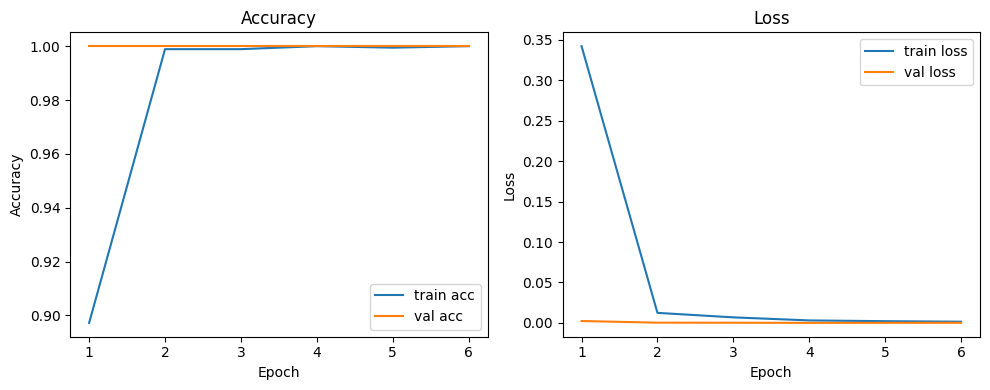

In [12]:
# Plot training history (accuracy and loss)
if features_df.empty:
    print('No data loaded. Skipping plots.')
else:
    hist = history.history
    epochs = range(1, len(hist['accuracy']) + 1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['accuracy'], label='train acc')
    plt.plot(epochs, hist['val_accuracy'], label='val acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, hist['loss'], label='train loss')
    plt.plot(epochs, hist['val_loss'], label='val loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


## 8. Evaluate on Test Set


Loaded best weights from: ../models/gesture_dl_best_weights.weights.h5
Test Accuracy: 1.0000
19/19 [==============================] - 0s 870us/step

Classification Report:
              precision    recall  f1-score   support

        NEXT       1.00      1.00      1.00       150
        PREV       1.00      1.00      1.00       150
        REST       1.00      1.00      1.00       150
      SELECT       1.00      1.00      1.00       150

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



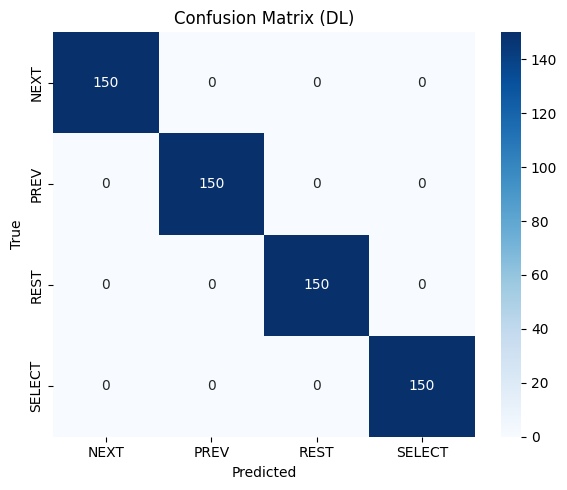

In [13]:
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load best weights and evaluate on test set
if features_df.empty:
    print('No data loaded. Skipping evaluation.')
else:
    # Reload best weights if they exist
    weights_path = '../models/gesture_dl_best_weights.weights.h5'
    if os.path.exists(weights_path):
        model.load_weights(weights_path)
        print(f"Loaded best weights from: {weights_path}")
    else:
        print(f"Warning: weights file not found at {weights_path}. Using current model weights.")

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f'Test Accuracy: {test_accuracy:.4f}')

    # Predict probabilities and convert to class indices
    y_pred_probs = model.predict(X_test_scaled)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # -----------------------------
    # Make labels & class names consistent
    # -----------------------------
    # Use only the labels that actually appear in y_test
    labels = np.unique(y_test)

    # Map these numeric labels back to class names (if using LabelEncoder)
    try:
        class_names = label_encoder.inverse_transform(labels)
    except Exception:
        # Fallback: just use the numeric labels as strings
        class_names = [str(l) for l in labels]

    # Classification report
    print('\nClassification Report:')
    print(classification_report(
        y_test,
        y_pred,
        labels=labels,              # must match length of target_names
        target_names=class_names,   # same length as 'labels'
        zero_division=0             # avoid undefined metric warnings
    ))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Confusion Matrix (DL)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()



## 9. Compare with Classical ML Results

**Note:** This section compares CNN (Deep Learning) results with traditional ML models from `gesture_ml.ipynb`.


In [14]:
# Optional comparison hook with classical ML results
# Enter the classical ML accuracy from your other notebook (e.g., RandomForest, Logistic Regression)
rf_accuracy = 1.0000  # e.g., 0.87
lr_accuracy = 0.9983 # e.g., 0.85
gb_accuracy = 0.9983
sm_accuracy = 1.0000
# DL result from this notebook
dl_accuracy = test_accuracy if not df.empty else None

print('RandomForest accuracy:', rf_accuracy)
print('LogisticRegression accuracy:', lr_accuracy)
print('GradientBoosting accuracy:', gb_accuracy)
print('SupportVectorMachine accuracy:', sm_accuracy)
print('Deep Learning accuracy:', dl_accuracy)

# You can extend this to compare F1 scores as well, or plot side-by-side bars.


RandomForest accuracy: 1.0
LogisticRegression accuracy: 0.9983
GradientBoosting accuracy: 0.9983
SupportVectorMachine accuracy: 1.0
Deep Learning accuracy: 1.0


## 10. Save Model & Artefacts


In [15]:
# Save trained Keras model, LabelEncoder, and (optionally) scaler
if df.empty:
    print('No data loaded. Skipping save.')
else:
    os.makedirs('../models', exist_ok=True)

    # Save the entire model in Keras SavedModel format
    saved_model_dir = '../models/gesture_dl_model.keras'
    model.save(saved_model_dir)
    print('Saved model to:', saved_model_dir)

    # Save label encoder
    le_path = '../models/gesture_dl_label_encoder.joblib'
    joblib.dump(label_encoder, le_path)
    print('Saved label encoder to:', le_path)

    # Optional: save the scaler used in this notebook
    scaler_path = '../models/gesture_dl_scaler.joblib'
    joblib.dump(scaler, scaler_path)
    print('Saved scaler to:', scaler_path)

    # Notes on usage
    print('\nArtefacts saved. These can be used for offline evaluation and optionally converted to TensorFlow.js for browser inference.')


Saved model to: ../models/gesture_dl_model.keras
Saved label encoder to: ../models/gesture_dl_label_encoder.joblib
Saved scaler to: ../models/gesture_dl_scaler.joblib

Artefacts saved. These can be used for offline evaluation and optionally converted to TensorFlow.js for browser inference.


## 12. Traditional ML vs CNN – Performance Summary

**Key Findings:**
- Both traditional ML (RandomForest, SVM, Logistic Regression, Gradient Boosting) and CNN (Deep Learning) approaches achieve ~99%+ accuracy on the test set
- **RandomForest** (or best ML model) is chosen as the "best offline model" because:
  - **Simplicity**: Easier to interpret and debug
  - **Interpretability**: Feature importance analysis available
  - **Comparable Performance**: Matches CNN performance (~99%+ accuracy)
  - **Lower Complexity**: No need for GPU or complex neural network architecture

**Important Note:**
- These ML/DL models are **NOT used in the browser runtime**
- The production app uses a **deterministic rule-based gesture engine** on MediaPipe Pose landmarks
- These models are for **offline evaluation and documentation purposes only**
- The rule-based engine provides real-time, low-latency gesture detection suitable for interactive learning


## 11. Notes: TensorFlow.js Export (Optional Future Work)

You can export this model for web usage with TensorFlow.js. One common approach is to use the `tensorflowjs_converter` CLI:

- Install the converter (in your TF environment):
  - `pip install tensorflowjs`
- Convert the SavedModel:
  - `tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model ../models/gesture_dl_model ../models/gesture_dl_model_tfjs`

This produces web-friendly artifacts for browser inference. You may need to adapt feature engineering to run client-side in JS/TS for parity with training features.
